## Announcments

Finally back! Had some deadlines and issues with gradio, kaggle, Firefox gtk rendering, quarto and jupyter but everything is working now. I’d like to give a shoutout to Kevin Liu for his help in getting up to speed with the updated gradio API. The example provided by Dr. Tanishq Abraham isn’t compatible with the updated version of Gradio so with Kevin’s notes on the gradio errors he ran into, I managed to get a model up on hugging face spaces with the new gradio syntax. 

## Summary 

In this lesson, Jeremy walks through a bear classification model example and then spends most of the lesson focusing on how to deploy a model into production. By production, Jeremy is referring to using a model outside of a Jupyter notebook. This is very useful because it provides a way for designing a custom inviting interface for interacting with a trained model. The decision of what the user interface should look like comes down to project scope, goals and the people using the model. 

If you’re a programmer, designer or learning deep learning like me, then it might be fun to hack around with javascript + the web to build a really nice interface. This can be a project in its own. The other group of people are data scientists, boss, team or people who need to interact with a prototype model ASAP. In that case, there are many handy python libraries and tools such as [colab](https://colab.research.google.com/), [altair](https://altair-viz.github.io/), [gradio](https://www.gradio.app/) and [streamlit](https://streamlit.io/) which provide a set of components that have been determined to be highly effective for rapid prototyping and sharing work on the web.

 If you are looking to build a nice application I would maybe start with gradio or streamlit for prototyping but then work with a designer or web developer to build a nicer interface since I’ve learned from personal experience that python libraries that render javascript, html and css can be a debugging nightmare when creating interactive web user interfaces.

Using gradio reminded me a lot of using streamlit. I remember liking streamlit for its simplicity in creating components but its simplicity was also its curse because of the nightmare it created when a user wanted to customize components beyond what the library offered. I really liked the gradio version that was used by Tanishq in his example because the syntax was very explicit about what the arguments and parameters mean in a gradio function. What tripped me up in the new gradio syntax was how complicated it was to debug and set up components. Once I managed to grasp the pattern and syntax from the gradio documentation it was a smoother experience but if I was new to python it would have been very difficult. I try to avoid using streamlit when I can and I probably will do the same with gradio but the experience setting it up and deploying a model on hugging face spaces with a web interface was worth learning. I might come back to this lesson in the future once I finish the rest of the course to experiment with how to deploy a model. 


## Terminology 

**Object Recognition** - Computers can recognize what items are in an image at least as well as people can.

**Object Detection** - Computers can recgonize where objects in an image are, and can highlight their locations and name each found object. 

**Segmentation** - A sub-area of `object detection` where every pixel is categorized on what kind of object it is part of 

**Data Augmentation** - creating random variations of our input data such that they appear different but do not change the information in the data. Augmentation techniques for images include rotation, flipping, perspective warping, brightness, contrast. 



## Picasso or Matisse Model 

Inspired by Jeremy’s bear example, I changed my Picasso Braque example from my previous post and decided to instead try two different artists who weren’t so similar, in this case I chose Henri Matisse and Pablo Picasso. I trained the model the same way I did the Picasso Braques example but one thing I noticed was that some of the images seemed off for a duckduckgo search where duckduckgo would pull up a portrait of Picasso that didn’t look like it was from the same period I was searching. To try and fix this I tried to refresh the notebook runs multiple times until I got base images from actual Picasso and Matisse paintings. Similar to the Picasso Braque example, my Picasso predictions were off even though the label was correct but the Matisse ones were accurate. 

After I tried Picasso and Matisse paintings, I tried different Picasso artworks such as his sculptures and got correct classifications. One person I shared the model with tried uploading their family thanksgiving photo to see what happened and the model classified the photo as 97%. This was quite intriguing to me because I had not even trained the model on images other than picasso and matisse paintings. I’m only writing on Lesson 2, but Jeremy’s discussion about transfer learning in Lesson 1 and the book has me wondering if the classification of the 97% Picasso Thanksgiving photo is a bug and use case I didn’t consider or if it has something to do with the resnet-18 base model with how it picked up the color, line and movement.


In [1]:
# install the latest libraries
!pip install -Uqq fastai duckduckgo_search

### Step 1: Gather Data

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# helper function for searching for images
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('Pablo Picasso Fauvism Paintings', max_images=1)
urls[0]

Searching for 'Pablo Picasso Fauvism Paintings'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://i.pinimg.com/736x/b5/69/e1/b569e151ba0a9adf0136f5bdd7d4401b.jpg'

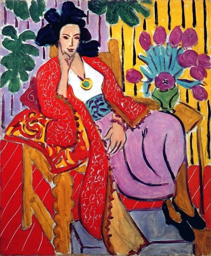

In [4]:
from fastdownload import download_url
from fastai.vision.all import *
dest = 'picasso.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for 'Henri Matisse Fauvism Paintings'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


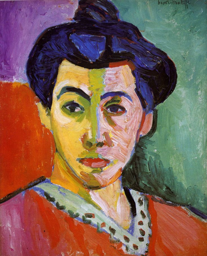

In [5]:
download_url(search_images('Henri Matisse Fauvism Paintings', max_images=1)[0],
            'matisse.jpg',
            show_progress=False)
Image.open('matisse.jpg').to_thumb(256, 256)

In [6]:
searches = 'Pablo Picasso', 'Henri Matisse'
path = Path('picasso_or_matisse')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest,urls=search_images(f'{o} fauvism paintings'))
    sleep(10) # sleep between searches to avoid spamming server
    download_images(dest,urls=search_images(f'{o} still life fauvism paintings'))
    sleep(10) # sleep between searches to avoid spamming server
    download_images(dest,urls=search_images(f'{o} fauvism scenic paintings'))
    sleep(10) # sleep between searches to avoid spamming server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Pablo Picasso fauvism paintings'
Searching for 'Pablo Picasso still life fauvism paintings'
Searching for 'Pablo Picasso fauvism scenic paintings'
Searching for 'Henri Matisse fauvism paintings'
Searching for 'Henri Matisse still life fauvism paintings'
Searching for 'Henri Matisse fauvism scenic paintings'


### Step 2: Train Model 

In [7]:
# remove images that failed to download properly
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

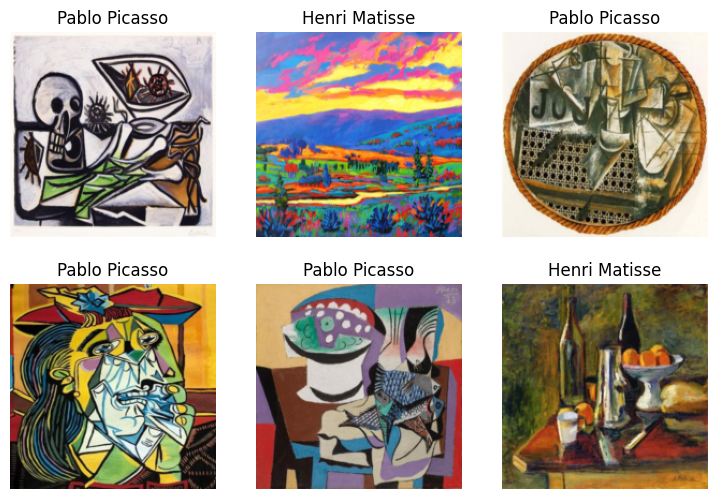

In [8]:
# split data into training set, validation set
dls = DataBlock(
    # specify input type(image), output type(category aka label)
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # split data into 80% training data, and 20% validation data
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # define the label
    get_y=parent_label,
    # standardize and resize all images to 192 x 192
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
# train a resnet model on the data
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.003311,0.399668,0.160377,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.362328,0.233523,0.084906,00:02
1,0.323960,0.221361,0.075472,00:03
2,0.253416,0.133047,0.037736,00:04
3,0.199347,0.111490,0.037736,00:02


### Step 3: Test Model

In [10]:
is_picasso,_,probs = learn.predict(PILImage.create('picasso.jpg'))
print(f"This is a: {is_picasso}.")
print(f"Probability it's a picasso: {probs[0]:.4f}")

This is a: Pablo Picasso.
Probability it's a picasso: 0.0005


In [11]:
is_matisse,_,probs = learn.predict(PILImage.create('matisse.jpg'))
print(f"This is a: {is_matisse}.")
print(f"Probability it's a matisse: {probs[0]:.4f}")

This is a: Henri Matisse.
Probability it's a matisse: 0.9936


### Step 4: Save and Export Model 

In [12]:
learn.export('model.pkl')

## Jeremy Howard's Advice 

- Train a model before data cleaning because it helps find data issues more quickly and easily.

## Gradio + Hugging Face Spaces 

The following code was originally written by Dr. Tanishq Abraham and published in the blog post: [Gradio + Hugging Face Spaces: A Tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html). It was modified by me and Kevin Liu to work with the current version of the gradio api. Currently the code works on Hugging Face Spaces but may break in the future as gradio continues updating its api.

My recommendation to get gradio and Hugging Face Spaces working is to start off with Tanishq's article and consult the gradio documentation to figure out the differences between the current version of the api and the version used in the article. I tried getting the pet classifier example working first before moving on to applying gradio to my Picasso Matisse Model which saved a lot of headache trying to figure out how git LFS and Hugging Face Spaces worked with my example. 

In [ ]:
import gradio as gr
from fastai.vision.all import *
import skimage

# load model 
learn = load_learner('model.pkl') 

# define prediction function 
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

# define interface structure 
title = "Picasso or Mattise Classifier"
description = "A classifier trained on Pablo Picasso and Henri Mattise paintings with fast.ai."
examples = ['picasso.jpg', 'matisse.jpg']
gr.Interface(fn=predict, inputs=[gr.Image(type="pil")], outputs=gr.Label(num_top_classes=3)).launch(share=True)

# interpretation = 'default'
# enable_queue = True 


# def greet(name):
#     return "Hello " + name + "!!"

# iface = gr.Interface(fn=greet, inputs="text", outputs="text")
# iface.launch()

## Resources

1. [Picasso or Mattise Gradio + Hugging Face Spaces](https://huggingface.co/spaces/mozartfish/picasso_or_matisse)
2. [FastAI Lesson 2](https://www.youtube.com/watch?v=F4tvM4Vb3A0)
3. [FastAI Chapter 2, Production](https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=-tldOlQyxQOf)
4. [Hugging Face Spaces](https://huggingface.co/spaces)
5. [Gradio](https://www.gradio.app/)
6. [How to Set Up an SSH Key(GitHub, Hugging Face Spaces)](https://www.youtube.com/watch?v=8X4u9sca3Io)
7. [Gradio + Hugging Face Spaces: A Tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html)
8. [Gradio Documentation](https://www.gradio.app/docs/interface)
9. [fastai Documentation](https://docs.fast.ai/)
